In [1]:
from electrode import network, brain, neuron
import networkx as nx
from brian2 import *

## Load in a brain network graph

In [2]:
net = network.Network(graph = nx.read_graphml('c_elegans_control.graphml'))
print(nx.info(net.graph))

Name: 
Type: DiGraph
Number of nodes: 397
Number of edges: 5279
Average in degree:  13.2972
Average out degree:  13.2972


## Create a brian2 brain

In [3]:
b2_brain = brain.Brian2_Brain()

In [4]:
#check that the neuron group dictionary is empty
b2_brain._neuron_groups

{}

### For example, we are going to add half of the nodes from the graph to the brain as LIF neurons and the other half as HH neurons

In [5]:
#set up the inputs for the LIF model
exectTime = 1*second
eqs = '''
    dv/dt = -(v-I/g)/tau : volt
    I : amp
    g : siemens'''
threshold='v > vth'
refractory='2*ms'
method='exact'
reset='v= vr' 

In [6]:
#set up the nodes to add to the LIF neuron group
neuron_list = list(net.graph.nodes)[0:198]
#set up the list of actiavtions for the LIF neurons
#this should be a list, with one value per neuron
activation_list = [25*nA] * 198

In [7]:
#add the LIF neuron group
b2_brain.add_group_of_neurons(neuron_list, 'LIF_neurons', neuron.Brian2_LeakyIntegrateandFire(neuron_list, activation_list, exectTime, eqs, threshold, refractory, method, reset))


In [8]:
#check that the neuron group was added
b2_brain._neuron_groups

{'LIF_neurons': <electrode.neuron.Brian2_LeakyIntegrateandFire at 0x7fc071543ca0>}

In [9]:
#repeat for the HH neurons

#set up the inputs for the HH model and add the neuron group
exectTime = 1*second
eqs = Equations('''
    dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt 
    dm/dt = 0.32*(mV**-1)*4*mV/exprel((13.*mV-v+VT)/(4*mV))/ms*(1-m)-0.28*(mV**-1)*5*mV/exprel((v-VT-40.*mV)/(5*mV))/ms*m : 1
    dn/dt = 0.032*(mV**-1)*5*mV/exprel((15.*mV-v+VT)/(5*mV))/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
    dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
    I : amp
    ''')
threshold='v > -40*mV'
refractory='v > -40*mV'
method='exponential_euler' 

activation_list = [.25*nA] * 199
neuron_list = list(net.graph.nodes)[198:-1]

b2_brain.add_group_of_neurons(neuron_list, 'HH_neurons', neuron.Brian2_HodgkinHuxley(neuron_list, activation_list, exectTime, eqs, threshold, refractory, method, reset))


In [10]:
#check that the neuron monitors were added to the brain
b2_brain._neuronmonitors

{'LIF_neurons': <StateMonitor, recording {'g', 'not_refractory', 'I', 'lastspike', 'v'} from neuron>,
 'HH_neurons': <StateMonitor, recording {'m', 'I', 'not_refractory', 'lastspike', 'n', 'h', 'v'} from neuron_1>}

In [11]:
#check that the synapse dictionary is empty
b2_brain._synapses

{}

In [12]:
#get the synapse edges from the graph
edges = net.graph.edges.data('weight', default=1)

In [13]:
#pull out the synapses that are within and between the neuron groups
HHedges = []
LIFedges = []
HH_LIFedges = []
for e in edges:
    if e[0] in b2_brain._neuron_groups['HH_neurons'].name_index.keys():
        if e[1] in b2_brain._neuron_groups['HH_neurons'].name_index.keys():
            HHedges.append(e)
        elif e[1] in b2_brain._neuron_groups['LIF_neurons'].name_index.keys():
            HH_LIFedges.append(e)
    elif e[0] in b2_brain._neuron_groups['LIF_neurons'].name_index.keys():
        if e[1] in b2_brain._neuron_groups['LIF_neurons'].name_index.keys():
            LIFedges.append(e)
        elif e[1] in b2_brain._neuron_groups['LIF_neurons'].name_index.keys():
            HH_LIFedges.append(e)
    


In [14]:
#set up inputs for the synapse creation
smodel = 'w:1'
on_pre = 'v_post+=w*100*mV'
#delay = 

In [15]:
#add the synapses between the HH neurons
source = b2_brain._neuron_groups['HH_neurons']
b2_brain.add_synapses('HHsynapses', source,source, HHedges, smodel, on_pre)

In [16]:
#add the synapses between the LIF neurons
source = b2_brain._neuron_groups['LIF_neurons']
b2_brain.add_synapses('LIFsynapses', source,source, LIFedges, smodel, on_pre)

In [17]:
#add the synapses between the HH and LIF neurons
source = b2_brain._neuron_groups['HH_neurons']
target = b2_brain._neuron_groups['LIF_neurons']
b2_brain.add_synapses('HH_LIFsynapses', source, target, HH_LIFedges, smodel, on_pre)

In [18]:
#check that synapse groups have been added
b2_brain._synapses

{'HHsynapses': Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses'),
 'LIFsynapses': Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses_1'),
 'HH_LIFsynapses': Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses_2')}

In [19]:
#run a simulation
b2_brain.run_simulation(50)

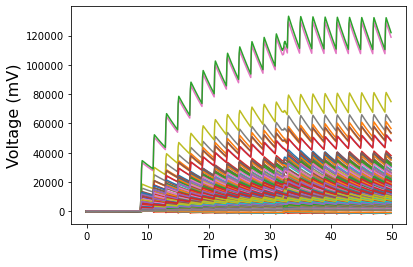

In [20]:
#plot neuron monitor info to test
statemon = b2_brain._neuronmonitors['LIF_neurons']

for i in range(0, 198):
        plot(statemon.t/ms,statemon.v[i]/mV)
        xlabel('Time (ms)', fontsize=16)
        ylabel('Voltage (mV)', fontsize=16)


In [21]:
#in order to run a new simulation we have to reset it
b2_brain.reset_stimulation()

In [22]:
#run a new simulation
b2_brain.run_simulation(50)

In [23]:
# you can also continue previous simulation to run it in steps
b2_brain.run_simulation(10)

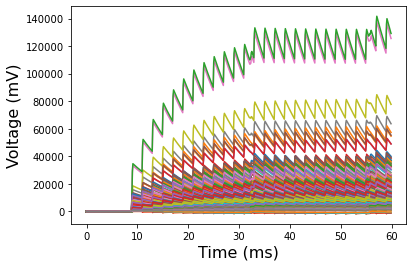

In [24]:
#plot neuron monitor info to test
statemon = b2_brain._neuronmonitors['LIF_neurons']

for i in range(0, 198):
        plot(statemon.t/ms,statemon.v[i]/mV)
        xlabel('Time (ms)', fontsize=16)
        ylabel('Voltage (mV)', fontsize=16)